In [53]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy
from scipy import signal
from scipy import ndimage

In [54]:
PATH = "E:\\Repo Scripts\\Level Set Codes\\Image\\3.bmp"
img = cv2.imread(PATH,0).astype(np.float32)
# plt.imshow(img,cmap='gray')

# C-V

In [55]:
def Heaviside(phi:np.ndarray,epsilon:int=1)->np.ndarray:
    H = 0.5*(1+ (2/np.pi)*np.arctan(phi/epsilon))
    return H
def Dirac(phi:np.ndarray,epsilon:int=1)->np.ndarray:
    Delta_h=(epsilon/np.pi)/(epsilon**2+ phi**2)
    return Delta_h
def NeumannBoundCond(g: np.ndarray) -> np.ndarray:
    #Make a function satisfy Neumann boundary condition
    nrow,ncol = g.shape
    g[1: nrow][1: ncol] = g[3: nrow-2][3: ncol-2]
    g[1: nrow][2: -1] = g[3:nrow-2][2:-1]
    g[2: -1][1: ncol] = g[2: -1][3: ncol-2]
    return g
def Calculate_c(Img:np.ndarray,H_phi:np.ndarray)->float:
    numer_1 = np.sum(H_phi*Img) 
    denom_1 = np.sum(H_phi)
    C1 = numer_1/denom_1

    numer_2 = np.sum((1-H_phi)*Img)
    denom_2 = np.sum(1-H_phi)
    C2 = numer_2/denom_2
    return C1,C2

In [56]:
def evolveLSF(I:np.ndarray,phi:np.ndarray,epoch:int,epsilon:float = 1,timestep:float = 0.1,lambda_1:float = 1., lambda_2: float = 1,nu:float = 1)->np.ndarray:
    for i in range(epoch):
        # phi = NeumannBoundCond(phi)
        dirac_phi = Dirac(phi)
        H_phi = Heaviside(phi, epsilon)
        # kappa = CURVATURE(phi,'cc')
        C1,C2 = Calculate_c(I,H_phi)
        # updating the phi function
        phi = phi+timestep*(dirac_phi*(nu-lambda_1*(I-C1)**2+lambda_2*(I-C2)**2))
    return phi


In [57]:
phi0 = np.ones((img.shape[0],img.shape[1]))
# phi0[int(3*img.shape[0]/10):int(7*img.shape[0]/10),int(3*img.shape[1]/10):int(7*img.shape[1]/10)] = -1
phi0[30:70,50:90] = -1
# plt.contour(phi0)

In [58]:
epsilon = 1.
lambda1 = 1. #inside
lambda2 = 1. #outside
mu = 1.  #length
nu = 0.  #area
epoch = 10

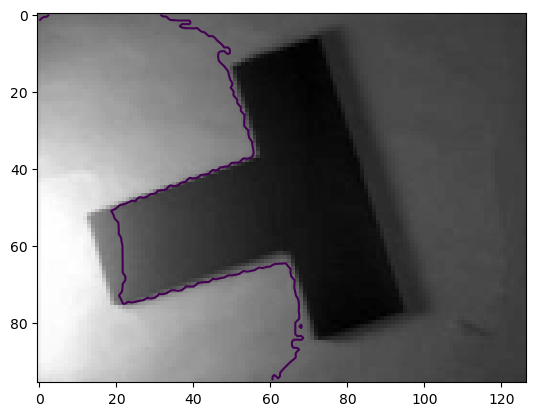

In [59]:
phi = evolveLSF(img,phi0,epoch)
plt.imshow(img,cmap='gray')
plt.contour(phi,[-1e-10,1e+10])
# plt.contour(np.flip(phi,0),[-1e-10,1e+10])

# RSF

In [16]:
def gaussian(x,mu,sigma):
    f_x = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-np.power(x-mu, 2.)/(2*np.power(sigma,2.)))
    return(f_x)

In [40]:
def gaussian_kernel(size:int=81,sigma:float=20.)->np.ndarray:
    G = np.multiply(cv2.getGaussianKernel(size, sigma), (cv2.getGaussianKernel(size, sigma)).T)
    return G
def get_curvature(phi:np.ndarray)->np.ndarray:
    [dx,dy] = np.gradient(phi,edge_order=2)
    norm = np.sqrt(dx*2+dy*2+1e-10)
    [dx_n,dy_n] = [dx,dy]/norm
    [ddx,tmp] = np.gradient(dx_n,edge_order=2)
    [tmp,ddy] = np.gradient(dy_n,edge_order=2)
    return ddx+ddy
def rsf_func(phi:np.ndarray,img:np.ndarray,k_gau:np.ndarray,k_img:np.ndarray,k_one:np.ndarray,
             mu:float,nu:float,timestep:int,lambda1:float,lambda2:float,epsilon:float,epoch:int)->np.ndarray:
    for i in range(epoch):
        curv = get_curvature(phi)
        dirac_phi = Dirac(phi,epsilon)
        H_phi = Heaviside(phi, epsilon)
        conv1 = scipy.signal.convolve(H_phi*img,k_gau,mode='same')
        conv2 = scipy.signal.convolve(H_phi,k_gau,mode='same')
        f1 = conv1/conv2
        f2 = (k_img-conv1)/(k_one-conv2)
        s1 = lambda1*f1**2-lambda2*f2**2                  
        s2 = lambda1*f1-lambda2*f2
        D = (lambda1-lambda2)*k_one*img*img+scipy.signal.convolve(s1,k_gau,mode='same')-2*img*scipy.signal.convolve(s2,k_gau,mode='same')#-dirac_phi*(lambda1*e1-lambda2*e2) #data fitting term
        L = nu-dirac_phi*curv #length term
        R = mu*(ndimage.laplace(phi)-curv) #regularization term
        res = D+L+R
    return res 
    
    


In [30]:
sigma = 20.
length = round(2*sigma)*2+1
timestep = 0.1
mu = 1.0
nu = 0.001*255*255
lambda1 = 1.0
lambda2 = 1.0
epsilon = 1.0
epoch = 10

In [51]:
phi0 = np.ones((img.shape[0],img.shape[1]))
# phi0[int(3*img.shape[0]/10):int(7*img.shape[0]/10),int(3*img.shape[1]/10):int(7*img.shape[1]/10)] = -1
phi0[30:70,50:90] = -1
k_gau = gaussian_kernel(length,sigma)
k_img = scipy.signal.convolve(img,k_gau,mode='same')
k_one = scipy.signal.convolve(np.ones(img.shape),k_gau,mode='same')
phi = rsf_func(phi0,img,k_gau,k_img,k_one,mu,nu,timestep,lambda1,lambda2,epsilon,epoch)

d:\miniconda\envs\env_cv\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


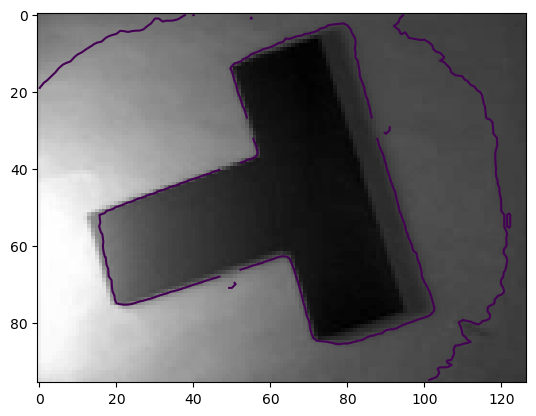

In [52]:
plt.imshow(img,cmap='gray')
plt.contour(phi,[-1e-10,1e+10])

In [19]:
np.linspace(2,8,4)

array([2., 4., 6., 8.])

In [13]:
np.gradient(phi0,edge_order=2)

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])]